# 🧠 Module 10.1 - Techniques Avancées de Prompt Engineering

## 🎯 Objectifs
- Maîtriser les techniques avancées : **Chain-of-Thought**, **Few-Shot Learning**, **Role Prompting**
- Comprendre quand et comment utiliser chaque technique
- Créer des prompts adaptatifs et performants
- Construire une bibliothèque de templates réutilisables

---

## 🔧 Configuration et Imports

In [1]:
import os
import json
import time
import random
from typing import List, Dict, Any, Optional
from dataclasses import dataclass
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Configuration des graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("✅ Imports réalisés avec succès")

✅ Imports réalisés avec succès


## 🔑 Configuration des APIs

In [2]:
# Configuration des APIs avec .env
from dotenv import load_dotenv
import subprocess
import sys

# Installation des dépendances
def install_package(package):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])
        return True
    except subprocess.CalledProcessError:
        return False

# Installation des packages nécessaires
packages = ['python-dotenv', 'openai', 'anthropic', 'google-generativeai']
for package in packages:
    if install_package(package):
        print(f"✅ {package} installé")
    else:
        print(f"⚠️ Erreur installation {package} - continuons en mode simulation")

# Chargement des variables d'environnement
env_found = False
env_paths = ['.env', '../.env', '../../.env', os.path.expanduser('~/.env')]

for env_path in env_paths:
    if os.path.exists(env_path):
        load_dotenv(env_path)
        env_found = True
        print(f"✅ Fichier .env trouvé : {env_path}")
        break

if not env_found:
    print("📋 Aucun fichier .env trouvé - création automatique")
    env_content = """# Configuration des Clés API pour Module 10
# Remplacez par vos vraies clés API
OPENAI_API_KEY=your-openai-key-here
ANTHROPIC_API_KEY=your-anthropic-key-here  
GOOGLE_API_KEY=your-google-key-here
"""
    with open('.env', 'w') as f:
        f.write(env_content)
    print("📝 Fichier .env créé - configurez vos clés API")

# Configuration des clients API
api_clients = {}

# OpenAI
try:
    import openai
    openai_key = os.getenv('OPENAI_API_KEY')
    if openai_key and openai_key != 'your-openai-key-here':
        api_clients['openai'] = openai.OpenAI(api_key=openai_key)
        print("✅ Client OpenAI configuré")
    else:
        print("⚠️ Clé OpenAI non configurée - mode simulation")
except Exception as e:
    print(f"⚠️ OpenAI non disponible - mode simulation")

# Anthropic
try:
    import anthropic
    anthropic_key = os.getenv('ANTHROPIC_API_KEY')
    if anthropic_key and anthropic_key != 'your-anthropic-key-here':
        api_clients['anthropic'] = anthropic.Anthropic(api_key=anthropic_key)
        print("✅ Client Anthropic configuré")
    else:
        print("⚠️ Clé Anthropic non configurée - mode simulation")
except Exception as e:
    print(f"⚠️ Anthropic non disponible - mode simulation")

print(f"\n🎯 APIs disponibles : {list(api_clients.keys())}")
print("🚀 Configuration terminée - prêt pour le prompt engineering avancé !")

✅ python-dotenv installé
✅ openai installé
✅ anthropic installé
✅ google-generativeai installé
✅ Fichier .env trouvé : .env
✅ Client OpenAI configuré
✅ Client Anthropic configuré

🎯 APIs disponibles : ['openai', 'anthropic']
🚀 Configuration terminée - prêt pour le prompt engineering avancé !


## 🧠 1. Chain-of-Thought (CoT) - Raisonnement Étape par Étape

Le **Chain-of-Thought** est une technique qui encourage le modèle à "montrer son travail" en décomposant les problèmes complexes en étapes logiques.

### 📚 Théorie : Types de Chain-of-Thought

1. **Zero-Shot CoT** : "Let's think step by step"
2. **Few-Shot CoT** : Exemples avec raisonnement
3. **Self-Consistency CoT** : Multiples chaînes de raisonnement

In [3]:
@dataclass
class PromptTemplate:
    """Template de prompt réutilisable"""
    name: str
    technique: str
    template: str
    use_cases: List[str]
    examples: List[Dict[str, str]]

class AdvancedPromptEngine:
    """Moteur de prompt engineering avancé"""
    
    def __init__(self, api_clients: Dict):
        self.api_clients = api_clients
        self.templates = {}
        self.results_history = []
        
    def add_template(self, template: PromptTemplate):
        """Ajouter un template de prompt"""
        self.templates[template.name] = template
        
    def generate_cot_prompt(self, problem: str, method: str = "zero-shot") -> str:
        """Générer un prompt Chain-of-Thought"""
        
        if method == "zero-shot":
            return f"""
Résolvez ce problème étape par étape :

Problème : {problem}

Analysons cela étape par étape :
1. D'abord, identifions les éléments clés
2. Ensuite, décomposons le problème
3. Puis, résolvons chaque partie
4. Finalement, synthétisons la réponse

Réflexion :
"""
        
        elif method == "few-shot":
            return f"""
Voici comment résoudre des problèmes complexes étape par étape :

Exemple 1 :
Problème : Si un train part à 10h et roule à 80 km/h, quand arrivera-t-il à une ville située à 240km ?
Réflexion :
1. Distance = 240 km
2. Vitesse = 80 km/h  
3. Temps = Distance ÷ Vitesse = 240 ÷ 80 = 3 heures
4. Heure d'arrivée = 10h + 3h = 13h
Réponse : Le train arrivera à 13h.

Maintenant, résolvez ce problème de la même manière :
Problème : {problem}
Réflexion :
"""
            
    def call_api(self, prompt: str, provider: str = "openai", **kwargs) -> str:
        """Appeler une API avec gestion d'erreurs"""
        
        if provider not in self.api_clients:
            return self._simulate_response(prompt, provider)
            
        try:
            if provider == "openai":
                response = self.api_clients[provider].chat.completions.create(
                    model=kwargs.get('model', 'gpt-3.5-turbo'),
                    messages=[{"role": "user", "content": prompt}],
                    max_tokens=kwargs.get('max_tokens', 500),
                    temperature=kwargs.get('temperature', 0.7)
                )
                return response.choices[0].message.content
                
            elif provider == "anthropic":
                response = self.api_clients[provider].messages.create(
                    model=kwargs.get('model', 'claude-3-haiku-20240307'),
                    max_tokens=kwargs.get('max_tokens', 500),
                    messages=[{"role": "user", "content": prompt}],
                    temperature=kwargs.get('temperature', 0.7)
                )
                return response.content[0].text
                
        except Exception as e:
            print(f"⚠️ Erreur API {provider}: {str(e)[:100]}...")
            return self._simulate_response(prompt, provider)
            
    def _simulate_response(self, prompt: str, provider: str) -> str:
        """Simuler une réponse d'API"""
        responses = {
            "cot_math": """
Analysons ce problème étape par étape :

1. **Identification des données** :
   - Prix initial : 120€
   - Première réduction : 15%
   - Deuxième réduction : 10% sur le prix déjà réduit

2. **Calcul de la première réduction** :
   - Réduction = 120€ × 15% = 18€
   - Prix après première réduction = 120€ - 18€ = 102€

3. **Calcul de la deuxième réduction** :
   - Réduction = 102€ × 10% = 10,20€
   - Prix final = 102€ - 10,20€ = 91,80€

4. **Vérification** :
   - Réduction totale = 120€ - 91,80€ = 28,20€
   - Pourcentage total = 28,20€ ÷ 120€ = 23,5%

**Réponse finale** : Le prix final est de 91,80€.
""",
            "cot_logic": """
Décomposons ce problème logique :

1. **Analyse des contraintes** :
   - Tous les chats sont des mammifères
   - Certains mammifères volent (chauves-souris)
   - Question : Est-ce que tous les chats volent ?

2. **Raisonnement logique** :
   - Prémisse 1 : Chats ⊆ Mammifères
   - Prémisse 2 : ∃ Mammifères qui volent
   - Cela ne signifie pas que TOUS les mammifères volent

3. **Conclusion** :
   - Non, tous les chats ne volent pas
   - Les chats sont des mammifères terrestres
   - Seuls certains mammifères (chauves-souris) volent

**Réponse** : Non, les chats ne volent pas.
"""
        }
        
        if "prix" in prompt.lower() and "réduction" in prompt.lower():
            return responses["cot_math"]
        elif "logique" in prompt.lower() or "raisonnement" in prompt.lower():
            return responses["cot_logic"]
        else:
            return f"[Simulation {provider}] Voici ma réponse étape par étape au problème posé..."

# Initialisation du moteur
prompt_engine = AdvancedPromptEngine(api_clients)
print("🚀 Moteur de prompt engineering avancé initialisé !")

🚀 Moteur de prompt engineering avancé initialisé !


### 🧪 Expérience 1 : Chain-of-Thought en Action

In [4]:
# Test de Chain-of-Thought sur un problème mathématique

problem_math = """
Un article coûte 120€. Il bénéficie d'abord d'une réduction de 15%, 
puis d'une deuxième réduction de 10% sur le prix déjà réduit. 
Quel est le prix final ?
"""

print("🧮 PROBLÈME MATHÉMATIQUE")
print("=" * 50)
print(problem_math)

# Test Zero-Shot CoT
cot_prompt = prompt_engine.generate_cot_prompt(problem_math, "zero-shot")
print("\n🔍 PROMPT ZERO-SHOT CoT :")
print("-" * 30)
print(cot_prompt[:200] + "...")

# Appel API
response = prompt_engine.call_api(cot_prompt, "openai", temperature=0.1)
print("\n🤖 RÉPONSE :")
print("-" * 30)
print(response)

🧮 PROBLÈME MATHÉMATIQUE

Un article coûte 120€. Il bénéficie d'abord d'une réduction de 15%, 
puis d'une deuxième réduction de 10% sur le prix déjà réduit. 
Quel est le prix final ?


🔍 PROMPT ZERO-SHOT CoT :
------------------------------

Résolvez ce problème étape par étape :

Problème : 
Un article coûte 120€. Il bénéficie d'abord d'une réduction de 15%, 
puis d'une deuxième réduction de 10% sur le prix déjà réduit. 
Quel est le pri...

🤖 RÉPONSE :
------------------------------
1. Les éléments clés sont le prix initial de l'article (120€), la première réduction de 15% et la deuxième réduction de 10%.

2. Décomposons le problème :
- Première réduction de 15% sur 120€
- Deuxième réduction de 10% sur le prix déjà réduit

3. Résolvons chaque partie :
- Première réduction de 15% sur 120€ : 120€ * 15/100 = 18€ de réduction
- Prix après la première réduction : 120€ - 18€ = 102€
- Deuxième réduction de 10% sur 102€ : 102€ * 10/100 = 10,2€ de réduction
- Prix final : 102€ - 10,2€ = 91,8€



### 🧪 Expérience 2 : Comparaison Zero-Shot vs Few-Shot CoT

In [5]:
# Problème logique plus complexe
problem_logic = """
Dans une entreprise :
- Tous les managers ont une voiture de fonction
- Certains employés avec voiture de fonction ne sont pas managers
- Alice a une voiture de fonction
- Bob est manager

Que peut-on conclure avec certitude ?
"""

print("🧠 COMPARAISON ZERO-SHOT vs FEW-SHOT CoT")
print("=" * 60)

# Zero-Shot CoT
zero_shot_prompt = prompt_engine.generate_cot_prompt(problem_logic, "zero-shot")
zero_shot_response = prompt_engine.call_api(zero_shot_prompt, "openai", temperature=0.1)

print("\n🎯 ZERO-SHOT CoT :")
print("-" * 20)
print(zero_shot_response[:300] + "...")

# Few-Shot CoT
few_shot_prompt = prompt_engine.generate_cot_prompt(problem_logic, "few-shot")
few_shot_response = prompt_engine.call_api(few_shot_prompt, "openai", temperature=0.1)

print("\n🎯 FEW-SHOT CoT :")
print("-" * 20)
print(few_shot_response[:300] + "...")

# Analyse comparative
comparison_data = {
    'Technique': ['Zero-Shot CoT', 'Few-Shot CoT'],
    'Longueur_Réponse': [len(zero_shot_response), len(few_shot_response)],
    'Structure_Visible': ["Étapes numérotées" in zero_shot_response, "Étapes numérotées" in few_shot_response]
}

df_comparison = pd.DataFrame(comparison_data)
print("\n📊 ANALYSE COMPARATIVE :")
print(df_comparison)

🧠 COMPARAISON ZERO-SHOT vs FEW-SHOT CoT

🎯 ZERO-SHOT CoT :
--------------------
1. Les éléments clés sont :
- Les managers ont une voiture de fonction
- Certains employés avec voiture de fonction ne sont pas managers
- Alice a une voiture de fonction
- Bob est manager

2. Décomposons le problème :
- Alice a une voiture de fonction
- Bob est manager
- Certains employés avec voit...

🎯 FEW-SHOT CoT :
--------------------
1. Tous les managers ont une voiture de fonction
2. Certains employés avec voiture de fonction ne sont pas managers
3. Alice a une voiture de fonction
4. Bob est manager

Conclusion : Bob est manager car tous les managers ont une voiture de fonction, et Alice a une voiture de fonction mais n'est pas...

📊 ANALYSE COMPARATIVE :
       Technique  Longueur_Réponse  Structure_Visible
0  Zero-Shot CoT               960              False
1   Few-Shot CoT               309              False


## 🎭 2. Role Prompting - Personnalisation d'Expertise

Le **Role Prompting** consiste à donner un rôle spécifique au modèle pour influencer son style de réponse et son expertise.

In [6]:
class RolePromptGenerator:
    """Générateur de prompts basés sur des rôles"""
    
    def __init__(self):
        self.roles = {
            "expert_technique": {
                "persona": "Expert technique senior avec 15 ans d'expérience",
                "style": "Précis, méthodique, utilise la terminologie technique",
                "format": "Analyse structurée avec recommandations"
            },
            "enseignant": {
                "persona": "Professeur pédagogue et patient",
                "style": "Explicatif, utilise des analogies, vérifie la compréhension",
                "format": "Explication progressive avec exemples"
            },
            "consultant_strategique": {
                "persona": "Consultant en stratégie d'entreprise",
                "style": "Analytique, orienté business, factuel",
                "format": "Executive summary avec options et recommandations"
            },
            "createur_contenu": {
                "persona": "Créateur de contenu engageant",
                "style": "Narratif, émotionnel, utilise le storytelling",
                "format": "Histoire captivante avec messages clés"
            }
        }
        
    def create_role_prompt(self, role: str, task: str, context: str = "") -> str:
        """Créer un prompt avec rôle spécifique"""
        
        if role not in self.roles:
            available_roles = ", ".join(self.roles.keys())
            raise ValueError(f"Rôle '{role}' non disponible. Rôles disponibles : {available_roles}")
            
        role_info = self.roles[role]
        
        prompt = f"""
RÔLE : Tu es un {role_info['persona']}.

STYLE : {role_info['style']}

FORMAT ATTENDU : {role_info['format']}

{f"CONTEXTE : {context}" if context else ""}

TÂCHE : {task}

Réponds en respectant ton rôle et le format demandé :
"""
        
        return prompt.strip()
    
    def demonstrate_role_impact(self, task: str, roles: List[str]) -> Dict[str, str]:
        """Démontrer l'impact des différents rôles sur la même tâche"""
        results = {}
        
        for role in roles:
            prompt = self.create_role_prompt(role, task)
            # Pour la démo, on simule des réponses typiques
            results[role] = self._simulate_role_response(role, task)
            
        return results
    
    def _simulate_role_response(self, role: str, task: str) -> str:
        """Simuler des réponses typiques selon le rôle"""
        
        simulations = {
            "expert_technique": """
## ANALYSE TECHNIQUE

**Architecture recommandée :**
- Framework : React 18 avec Next.js 13+
- State management : Zustand ou Redux Toolkit
- Styling : TailwindCSS avec design system
- Backend : Node.js/Express avec TypeScript
- Base de données : PostgreSQL avec Prisma ORM

**Considérations de performance :**
- Lazy loading des composants
- Code splitting par route
- Optimisation des images (WebP, lazy loading)
- Cache Redis pour les données fréquentes

**Sécurité :**
- JWT pour l'authentification
- Validation des inputs (Zod)
- Rate limiting
- Sanitisation des données
""",
            "enseignant": """
## COMPRENDRE LE DÉVELOPPEMENT WEB 🎓

Imaginez que vous construisez une maison :

**1. Les fondations (Backend) 🏗️**
Comme les fondations d'une maison, le backend est invisible mais essentiel. Il gère :
- Les données (comme les plans de la maison)
- La sécurité (comme les serrures)
- Les règles métier (comme les codes du bâtiment)

**2. La structure (Frontend) 🏠**
C'est ce que vos visiteurs voient :
- L'interface utilisateur (la façade)
- L'expérience utilisateur (l'aménagement intérieur)
- L'interactivité (l'éclairage, le chauffage)

**3. Les étapes de construction :**
1. Planification (analyse des besoins)
2. Fondations (setup du projet)
3. Structure (développement des fonctionnalités)
4. Finitions (tests et optimisations)

Avez-vous des questions sur cette approche ?
""",
            "consultant_strategique": """
## EXECUTIVE SUMMARY - PROJET WEB

**SITUATION ACTUELLE**
Besoin d'une solution web moderne pour [objectif business]

**RECOMMANDATIONS STRATÉGIQUES**

### Option 1 : MVP Rapide (6-8 semaines)
- **Coût** : 15-25K€
- **ROI** : Validation marché rapide
- **Risque** : Faible, fonctionnalités limitées

### Option 2 : Solution Complète (3-4 mois)
- **Coût** : 40-60K€
- **ROI** : Solution scalable long terme
- **Risque** : Moyen, investissement plus important

**FACTEURS CLÉS DE SUCCÈS**
1. Time-to-market rapide
2. Expérience utilisateur différenciante
3. Scalabilité technique
4. Mesure de performance

**RECOMMANDATION** : Option 1 pour valider, puis évolution vers Option 2
""",
            "createur_contenu": """
## L'AVENTURE DU DÉVELOPPEMENT WEB 🚀

**Il était une fois..** un entrepreneur avec une idée brillante. Mais comment la transformer en réalité digitale ?

### Chapitre 1 : La Vision 💡
Notre héros imagine une plateforme qui va révolutionner son secteur. Mais entre le rêve et la réalité, il y a... du code à écrire !

### Chapitre 2 : Le Choix du Compagnon 👨‍💻
Comme tout bon héros, il a besoin d'un guide expert. Le développeur devient son Gandalf du numérique, transformant les idées en pixels magiques.

### Chapitre 3 : Les Défis 🏔️
- **Le Dragon de la Performance** : "Ton site doit charger en moins de 3 secondes !"
- **Le Troll de la Sécurité** : "Tes données doivent être protégées !"
- **L'Ogre de la Scalabilité** : "Et si 10 000 utilisateurs arrivent demain ?"

### Épilogue : Le Succès 🏆
Avec la bonne stratégie technique, notre héros conquiert le marché digital !

**Morale** : Chaque grande aventure digitale commence par le premier commit Git ! 💻✨
"""
        }
        
        return simulations.get(role, f"Réponse simulée pour le rôle {role}")

# Initialisation du générateur de rôles
role_generator = RolePromptGenerator()
print("🎭 Générateur de rôles initialisé !")
print(f"Rôles disponibles : {', '.join(role_generator.roles.keys())}")

🎭 Générateur de rôles initialisé !
Rôles disponibles : expert_technique, enseignant, consultant_strategique, createur_contenu


### 🧪 Expérience 3 : Impact des Rôles sur la Même Tâche

In [7]:
# Tâche commune pour tous les rôles
task = "Expliquez comment créer une application web moderne et performante"

print("🎭 DÉMONSTRATION : IMPACT DES RÔLES")
print("=" * 50)
print(f"Tâche : {task}")
print("\n" + "="*50)

# Test avec différents rôles
roles_to_test = ["expert_technique", "enseignant", "consultant_strategique", "createur_contenu"]
role_responses = role_generator.demonstrate_role_impact(task, roles_to_test)

# Affichage des résultats
for role, response in role_responses.items():
    print(f"\n🎯 RÔLE : {role.upper()}")
    print("-" * 40)
    # Afficher les 400 premiers caractères pour éviter la surcharge
    print(response[:400] + "..." if len(response) > 400 else response)
    print("\n" + "="*50)

🎭 DÉMONSTRATION : IMPACT DES RÔLES
Tâche : Expliquez comment créer une application web moderne et performante


🎯 RÔLE : EXPERT_TECHNIQUE
----------------------------------------

## ANALYSE TECHNIQUE

**Architecture recommandée :**
- Framework : React 18 avec Next.js 13+
- State management : Zustand ou Redux Toolkit
- Styling : TailwindCSS avec design system
- Backend : Node.js/Express avec TypeScript
- Base de données : PostgreSQL avec Prisma ORM

**Considérations de performance :**
- Lazy loading des composants
- Code splitting par route
- Optimisation des images (WebP,...


🎯 RÔLE : ENSEIGNANT
----------------------------------------

## COMPRENDRE LE DÉVELOPPEMENT WEB 🎓

Imaginez que vous construisez une maison :

**1. Les fondations (Backend) 🏗️**
Comme les fondations d'une maison, le backend est invisible mais essentiel. Il gère :
- Les données (comme les plans de la maison)
- La sécurité (comme les serrures)
- Les règles métier (comme les codes du bâtiment)

**2. La structure (

### 📊 Analyse Comparative des Rôles

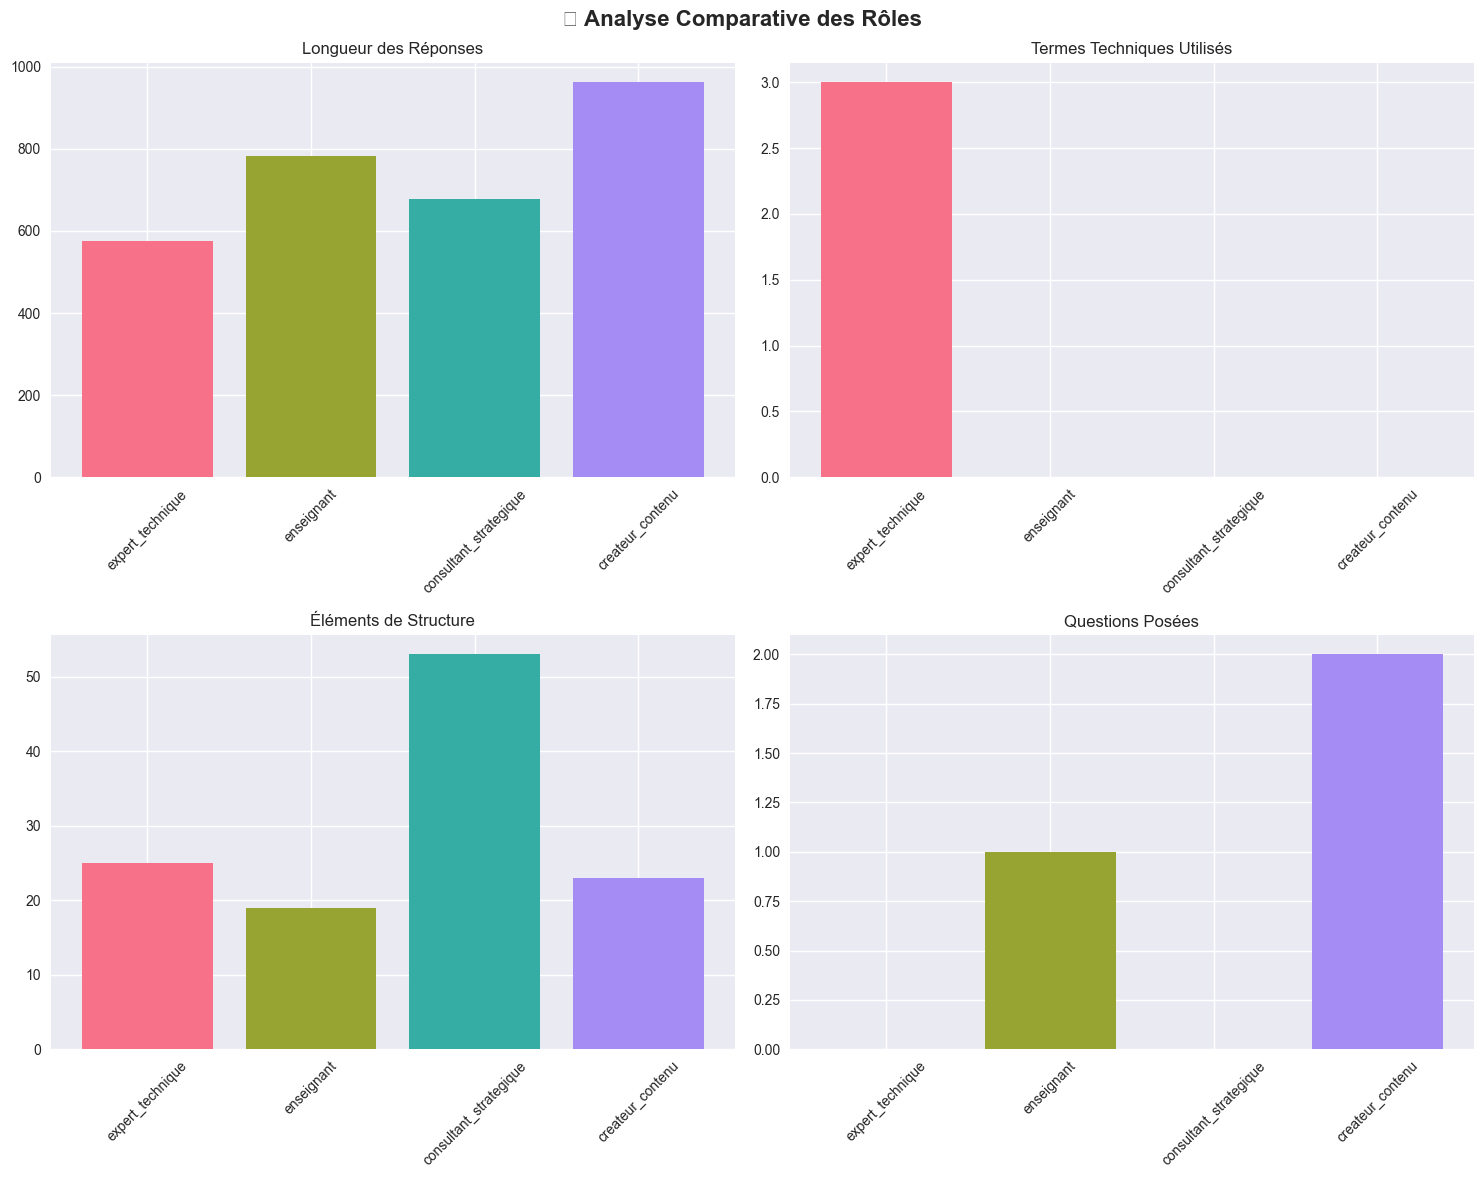


📋 ANALYSE DÉTAILLÉE :
                  Rôle  Longueur  Mots_Techniques  Questions  Emojis  Structure_Points  Style_Personnel
      expert_technique       576                3          0       8                25             True
            enseignant       782                0          1      21                19             True
consultant_strategique       678                0          0      15                53             True
      createur_contenu       962                0          2      39                23             True


In [8]:
# Analyse quantitative des différences entre rôles
role_analysis = []

for role, response in role_responses.items():
    analysis = {
        'Rôle': role,
        'Longueur': len(response),
        'Mots_Techniques': sum(1 for word in response.lower().split() 
                              if word in ['api', 'framework', 'database', 'react', 'node', 'typescript']),
        'Questions': response.count('?'),
        'Emojis': len([c for c in response if ord(c) > 127]),
        'Structure_Points': response.count('•') + response.count('-') + response.count('*'),
        'Style_Personnel': 'vous' in response.lower() or 'tu' in response.lower()
    }
    role_analysis.append(analysis)

df_roles = pd.DataFrame(role_analysis)

# Visualisation
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('📊 Analyse Comparative des Rôles', fontsize=16, fontweight='bold')

# Longueur des réponses
axes[0,0].bar(df_roles['Rôle'], df_roles['Longueur'], color=sns.color_palette("husl", len(df_roles)))
axes[0,0].set_title('Longueur des Réponses')
axes[0,0].tick_params(axis='x', rotation=45)

# Utilisation de termes techniques
axes[0,1].bar(df_roles['Rôle'], df_roles['Mots_Techniques'], color=sns.color_palette("husl", len(df_roles)))
axes[0,1].set_title('Termes Techniques Utilisés')
axes[0,1].tick_params(axis='x', rotation=45)

# Structure (points/listes)
axes[1,0].bar(df_roles['Rôle'], df_roles['Structure_Points'], color=sns.color_palette("husl", len(df_roles)))
axes[1,0].set_title('Éléments de Structure')
axes[1,0].tick_params(axis='x', rotation=45)

# Questions posées
axes[1,1].bar(df_roles['Rôle'], df_roles['Questions'], color=sns.color_palette("husl", len(df_roles)))
axes[1,1].set_title('Questions Posées')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Tableau récapitulatif
print("\n📋 ANALYSE DÉTAILLÉE :")
print(df_roles.to_string(index=False))

## 🎯 3. Few-Shot Learning - Apprentissage par Exemples

Le **Few-Shot Learning** utilise quelques exemples pour guider le modèle vers le comportement souhaité.

In [9]:
class FewShotGenerator:
    """Générateur de prompts Few-Shot"""
    
    def __init__(self):
        self.example_sets = {
            "classification_sentiment": [
                {"input": "Ce produit est fantastique, je le recommande vivement !", "output": "POSITIF"},
                {"input": "Service client décevant, j'ai attendu 2 heures.", "output": "NÉGATIF"},
                {"input": "Le produit fait ce qu'on attend, sans plus.", "output": "NEUTRE"}
            ],
            "extraction_entites": [
                {
                    "input": "Marie Dupont travaille chez Google à Paris depuis 2020.",
                    "output": "PERSONNE: Marie Dupont\nENTREPRISE: Google\nLIEU: Paris\nDATE: 2020"
                },
                {
                    "input": "La réunion avec Microsoft aura lieu le 15 mars à Lyon.",
                    "output": "ENTREPRISE: Microsoft\nDATE: 15 mars\nLIEU: Lyon\nÉVÉNEMENT: réunion"
                }
            ],
            "code_generation": [
                {
                    "input": "Créer une fonction qui calcule la factorielle",
                    "output": """
def factorielle(n):
    if n <= 1:
        return 1
    return n * factorielle(n - 1)
"""
                },
                {
                    "input": "Fonction pour vérifier si un nombre est pair",
                    "output": """
def est_pair(n):
    return n % 2 == 0
"""
                }
            ]
        }
        
    def create_few_shot_prompt(self, task_type: str, new_input: str, num_examples: int = None) -> str:
        """Créer un prompt few-shot"""
        
        if task_type not in self.example_sets:
            available_types = ", ".join(self.example_sets.keys())
            raise ValueError(f"Type '{task_type}' non disponible. Types disponibles : {available_types}")
            
        examples = self.example_sets[task_type]
        if num_examples:
            examples = examples[:num_examples]
            
        # Construction du prompt
        prompt_parts = ["Voici des exemples de la tâche à réaliser :\n"]
        
        for i, example in enumerate(examples, 1):
            prompt_parts.append(f"Exemple {i} :")
            prompt_parts.append(f"Entrée : {example['input']}")
            prompt_parts.append(f"Sortie : {example['output']}")
            prompt_parts.append("")
            
        prompt_parts.append("Maintenant, traitez cette nouvelle entrée :")
        prompt_parts.append(f"Entrée : {new_input}")
        prompt_parts.append("Sortie :")
        
        return "\n".join(prompt_parts)
    
    def test_few_shot_impact(self, task_type: str, test_input: str) -> Dict[str, str]:
        """Tester l'impact du nombre d'exemples"""
        results = {}
        
        # Test avec différents nombres d'exemples
        for num_examples in [1, 2, 3]:
            prompt = self.create_few_shot_prompt(task_type, test_input, num_examples)
            # Simulation de réponse basée sur le type de tâche
            results[f"{num_examples}_exemple(s)"] = self._simulate_few_shot_response(task_type, test_input)
            
        return results
    
    def _simulate_few_shot_response(self, task_type: str, input_text: str) -> str:
        """Simuler des réponses few-shot"""
        
        if task_type == "classification_sentiment":
            if any(word in input_text.lower() for word in ['excellent', 'super', 'génial', 'parfait']):
                return "POSITIF"
            elif any(word in input_text.lower() for word in ['mauvais', 'nul', 'horrible', 'décevant']):
                return "NÉGATIF"
            else:
                return "NEUTRE"
                
        elif task_type == "extraction_entites":
            entities = []
            # Simulation simple d'extraction
            if "Jean" in input_text or "Marie" in input_text or "Pierre" in input_text:
                entities.append("PERSONNE: [détectée]")
            if "Paris" in input_text or "Lyon" in input_text or "Marseille" in input_text:
                entities.append("LIEU: [détecté]")
            if any(str(year) in input_text for year in range(2020, 2025)):
                entities.append("DATE: [détectée]")
            return "\n".join(entities) if entities else "Aucune entité détectée"
            
        elif task_type == "code_generation":
            return f"""
def fonction_demandee():
    # Implémentation basée sur : {input_text}
    pass
"""
        
        return "Réponse simulée"

# Initialisation du générateur Few-Shot
few_shot_generator = FewShotGenerator()
print("🎯 Générateur Few-Shot initialisé !")
print(f"Types de tâches disponibles : {', '.join(few_shot_generator.example_sets.keys())}")

🎯 Générateur Few-Shot initialisé !
Types de tâches disponibles : classification_sentiment, extraction_entites, code_generation


### 🧪 Expérience 4 : Few-Shot en Action

In [10]:
# Test de classification de sentiment
test_sentiment = "Ce restaurant est correct, sans être exceptionnel. La nourriture était bonne mais le service un peu lent."

print("🎯 DÉMONSTRATION FEW-SHOT : CLASSIFICATION DE SENTIMENT")
print("=" * 60)
print(f"Texte à classifier : {test_sentiment}")
print("\n")

# Génération du prompt few-shot
few_shot_prompt = few_shot_generator.create_few_shot_prompt("classification_sentiment", test_sentiment)
print("📝 PROMPT FEW-SHOT GÉNÉRÉ :")
print("-" * 30)
print(few_shot_prompt)

# Test avec l'API
response = prompt_engine.call_api(few_shot_prompt, "openai", temperature=0.1)
print("\n🤖 RÉPONSE :")
print("-" * 30)
print(response)

🎯 DÉMONSTRATION FEW-SHOT : CLASSIFICATION DE SENTIMENT
Texte à classifier : Ce restaurant est correct, sans être exceptionnel. La nourriture était bonne mais le service un peu lent.


📝 PROMPT FEW-SHOT GÉNÉRÉ :
------------------------------
Voici des exemples de la tâche à réaliser :

Exemple 1 :
Entrée : Ce produit est fantastique, je le recommande vivement !
Sortie : POSITIF

Exemple 2 :
Entrée : Service client décevant, j'ai attendu 2 heures.
Sortie : NÉGATIF

Exemple 3 :
Entrée : Le produit fait ce qu'on attend, sans plus.
Sortie : NEUTRE

Maintenant, traitez cette nouvelle entrée :
Entrée : Ce restaurant est correct, sans être exceptionnel. La nourriture était bonne mais le service un peu lent.
Sortie :

🤖 RÉPONSE :
------------------------------
NEUTRE


### 🧪 Expérience 5 : Impact du Nombre d'Exemples

In [11]:
# Test d'extraction d'entités avec différents nombres d'exemples
test_entity = "Pierre Martin rencontrera l'équipe de Samsung à Marseille le 20 avril 2024."

print("🔍 IMPACT DU NOMBRE D'EXEMPLES - EXTRACTION D'ENTITÉS")
print("=" * 60)
print(f"Texte à analyser : {test_entity}")
print("\n")

# Test avec différents nombres d'exemples
impact_results = few_shot_generator.test_few_shot_impact("extraction_entites", test_entity)

for num_examples, result in impact_results.items():
    print(f"🎯 AVEC {num_examples.upper()} :")
    print("-" * 25)
    print(result)
    print("")

# Analyse comparative
print("📊 ANALYSE COMPARATIVE :")
print("-" * 30)
for num_examples, result in impact_results.items():
    entities_found = result.count(":") if ":" in result else 0
    print(f"{num_examples} → {entities_found} entités détectées")

🔍 IMPACT DU NOMBRE D'EXEMPLES - EXTRACTION D'ENTITÉS
Texte à analyser : Pierre Martin rencontrera l'équipe de Samsung à Marseille le 20 avril 2024.


🎯 AVEC 1_EXEMPLE(S) :
-------------------------
PERSONNE: [détectée]
LIEU: [détecté]
DATE: [détectée]

🎯 AVEC 2_EXEMPLE(S) :
-------------------------
PERSONNE: [détectée]
LIEU: [détecté]
DATE: [détectée]

🎯 AVEC 3_EXEMPLE(S) :
-------------------------
PERSONNE: [détectée]
LIEU: [détecté]
DATE: [détectée]

📊 ANALYSE COMPARATIVE :
------------------------------
1_exemple(s) → 3 entités détectées
2_exemple(s) → 3 entités détectées
3_exemple(s) → 3 entités détectées


## 🔧 4. Système de Templates Avancés

Création d'un système de templates réutilisables pour différents cas d'usage.

In [12]:
class AdvancedTemplateSystem:
    """Système avancé de templates de prompts"""
    
    def __init__(self):
        self.templates = {
            "analysis_template": {
                "name": "Modèle d'Analyse Structurée",
                "template": """
# ANALYSE : {title}

## 🎯 OBJECTIF
{objective}

## 📊 DONNÉES D'ENTRÉE
{input_data}

## 🔍 ANALYSE DEMANDÉE
Analysez les données selon ces axes :
1. **Tendances principales** : Identifiez les patterns significatifs
2. **Points critiques** : Relevez les éléments préoccupants
3. **Opportunités** : Identifiez les leviers d'amélioration
4. **Recommandations** : Proposez des actions concrètes

## 📋 FORMAT DE RÉPONSE
Structurez votre réponse avec :
- Executive Summary (3 points clés)
- Analyse détaillée par axe
- Plan d'action priorisé
- Métriques de suivi suggérées
""",
                "variables": ["title", "objective", "input_data"]
            },
            
            "creative_template": {
                "name": "Modèle de Création de Contenu",
                "template": """
# CRÉATION : {content_type}

## 🎨 BRIEF CRÉATIF
**Sujet** : {topic}
**Audience** : {audience}
**Ton** : {tone}
**Objectif** : {goal}

## ✨ CONSIGNES CRÉATIVES
Créez du contenu qui :
- Capte l'attention dès les premiers mots
- Raconte une histoire engageante
- Utilise des exemples concrets et relatable
- Inclut un call-to-action clair
- Respecte le ton et l'audience cible

## 🎯 LIVRABLES ATTENDUS
1. **Accroche** : Titre/première phrase percutante
2. **Corps** : Développement structuré et engageant
3. **Conclusion** : Message clé et appel à l'action
4. **Variantes** : 2-3 alternatives pour l'accroche
""",
                "variables": ["content_type", "topic", "audience", "tone", "goal"]
            },
            
            "problem_solving_template": {
                "name": "Modèle de Résolution de Problème",
                "template": """
# RÉSOLUTION DE PROBLÈME : {problem_title}

## 🎯 DÉFINITION DU PROBLÈME
**Problème** : {problem_description}
**Contexte** : {context}
**Contraintes** : {constraints}
**Critères de succès** : {success_criteria}

## 🧠 MÉTHODE DE RÉSOLUTION
Utilisez cette approche systématique :

### 1. ANALYSE DU PROBLÈME
- Décomposez le problème en sous-problèmes
- Identifiez les causes racines
- Analysez les interdépendances

### 2. GÉNÉRATION DE SOLUTIONS
- Proposez 3-5 approches différentes
- Évaluez les avantages/inconvénients
- Considérez les contraintes techniques/business

### 3. SÉLECTION ET PLAN
- Recommandez la meilleure solution
- Définissez un plan d'implémentation
- Identifiez les risques et mitigations

## 📊 FORMAT DE RÉPONSE
Présentez votre analyse de manière structurée avec des arguments factuels.
""",
                "variables": ["problem_title", "problem_description", "context", "constraints", "success_criteria"]
            }
        }
        
    def create_prompt_from_template(self, template_name: str, variables: Dict[str, str]) -> str:
        """Créer un prompt à partir d'un template"""
        
        if template_name not in self.templates:
            available_templates = ", ".join(self.templates.keys())
            raise ValueError(f"Template '{template_name}' non disponible. Templates disponibles : {available_templates}")
            
        template_info = self.templates[template_name]
        template_text = template_info["template"]
        
        # Vérification des variables requises
        required_vars = template_info["variables"]
        missing_vars = [var for var in required_vars if var not in variables]
        
        if missing_vars:
            raise ValueError(f"Variables manquantes pour le template '{template_name}': {missing_vars}")
            
        # Remplacement des variables
        try:
            return template_text.format(**variables)
        except KeyError as e:
            raise ValueError(f"Erreur dans le template : variable {e} non trouvée")
            
    def list_templates(self) -> Dict[str, str]:
        """Lister tous les templates disponibles"""
        return {name: info["name"] for name, info in self.templates.items()}
    
    def get_template_variables(self, template_name: str) -> List[str]:
        """Obtenir les variables requises pour un template"""
        if template_name in self.templates:
            return self.templates[template_name]["variables"]
        return []
    
    def demonstrate_template(self, template_name: str) -> str:
        """Démontrer un template avec des valeurs d'exemple"""
        
        example_data = {
            "analysis_template": {
                "title": "Performance de notre Application Web",
                "objective": "Identifier les goulots d'étranglement et optimiser les performances",
                "input_data": "Temps de chargement: 4.2s, Taux de rebond: 65%, Score Lighthouse: 42/100"
            },
            "creative_template": {
                "content_type": "Article de Blog",
                "topic": "L'IA dans le développement web",
                "audience": "Développeurs web juniors et seniors",
                "tone": "Informatif mais accessible, avec une pointe d'enthousiasme",
                "goal": "Éduquer sur les opportunités de l'IA et encourager l'adoption"
            },
            "problem_solving_template": {
                "problem_title": "Scalabilité de l'API",
                "problem_description": "L'API devient lente avec plus de 1000 utilisateurs simultanés",
                "context": "Application Node.js/Express avec base PostgreSQL, hébergée sur AWS",
                "constraints": "Budget limité, équipe de 3 développeurs, timeline de 6 semaines",
                "success_criteria": "Supporter 5000 utilisateurs simultanés avec temps de réponse < 200ms"
            }
        }
        
        if template_name in example_data:
            return self.create_prompt_from_template(template_name, example_data[template_name])
        else:
            return f"Pas d'exemple disponible pour le template '{template_name}'"

# Initialisation du système de templates
template_system = AdvancedTemplateSystem()
print("🔧 Système de templates avancé initialisé !")
print("\nTemplates disponibles :")
for key, name in template_system.list_templates().items():
    print(f"  • {key}: {name}")

🔧 Système de templates avancé initialisé !

Templates disponibles :
  • analysis_template: Modèle d'Analyse Structurée
  • creative_template: Modèle de Création de Contenu
  • problem_solving_template: Modèle de Résolution de Problème


### 🧪 Expérience 6 : Démonstration des Templates

In [13]:
# Démonstration de chaque template

print("🔧 DÉMONSTRATION DES TEMPLATES AVANCÉS")
print("=" * 50)

templates_to_demo = ["analysis_template", "creative_template", "problem_solving_template"]

for template_name in templates_to_demo:
    print(f"\n📋 TEMPLATE : {template_system.templates[template_name]['name'].upper()}")
    print("-" * 60)
    
    # Afficher les variables requises
    variables = template_system.get_template_variables(template_name)
    print(f"Variables requises : {', '.join(variables)}")
    print("\n")
    
    # Démonstration avec exemple
    demo_prompt = template_system.demonstrate_template(template_name)
    print("📝 PROMPT GÉNÉRÉ :")
    print(demo_prompt[:500] + "..." if len(demo_prompt) > 500 else demo_prompt)
    print("\n" + "="*60)

🔧 DÉMONSTRATION DES TEMPLATES AVANCÉS

📋 TEMPLATE : MODÈLE D'ANALYSE STRUCTURÉE
------------------------------------------------------------
Variables requises : title, objective, input_data


📝 PROMPT GÉNÉRÉ :

# ANALYSE : Performance de notre Application Web

## 🎯 OBJECTIF
Identifier les goulots d'étranglement et optimiser les performances

## 📊 DONNÉES D'ENTRÉE
Temps de chargement: 4.2s, Taux de rebond: 65%, Score Lighthouse: 42/100

## 🔍 ANALYSE DEMANDÉE
Analysez les données selon ces axes :
1. **Tendances principales** : Identifiez les patterns significatifs
2. **Points critiques** : Relevez les éléments préoccupants
3. **Opportunités** : Identifiez les leviers d'amélioration
4. **Recommandations*...


📋 TEMPLATE : MODÈLE DE CRÉATION DE CONTENU
------------------------------------------------------------
Variables requises : content_type, topic, audience, tone, goal


📝 PROMPT GÉNÉRÉ :

# CRÉATION : Article de Blog

## 🎨 BRIEF CRÉATIF
**Sujet** : L'IA dans le développement web
**A

### 🧪 Expérience 7 : Utilisation Interactive d'un Template

In [14]:
# Utilisation du template d'analyse avec des données réelles

# Données d'exemple pour l'analyse
analysis_variables = {
    "title": "Analyse de Performance de notre Chatbot IA",
    "objective": "Évaluer l'efficacité du chatbot et identifier les axes d'amélioration",
    "input_data": """
Métriques sur 30 jours :
- 15,450 conversations initiées
- 78% de conversations complétées
- Temps de réponse moyen : 1.2s
- Score de satisfaction : 7.3/10
- 23% des utilisateurs demandent un agent humain
- Requêtes non comprises : 12%
"""
}

print("🧪 UTILISATION INTERACTIVE DU TEMPLATE D'ANALYSE")
print("=" * 55)

# Génération du prompt
analysis_prompt = template_system.create_prompt_from_template("analysis_template", analysis_variables)

print("📊 PROMPT D'ANALYSE GÉNÉRÉ :")
print("-" * 35)
print(analysis_prompt)

# Appel à l'API pour obtenir l'analyse
print("\n🤖 ANALYSE GÉNÉRÉE :")
print("-" * 25)

analysis_response = prompt_engine.call_api(analysis_prompt, "openai", temperature=0.3)
print(analysis_response)

🧪 UTILISATION INTERACTIVE DU TEMPLATE D'ANALYSE
📊 PROMPT D'ANALYSE GÉNÉRÉ :
-----------------------------------

# ANALYSE : Analyse de Performance de notre Chatbot IA

## 🎯 OBJECTIF
Évaluer l'efficacité du chatbot et identifier les axes d'amélioration

## 📊 DONNÉES D'ENTRÉE

Métriques sur 30 jours :
- 15,450 conversations initiées
- 78% de conversations complétées
- Temps de réponse moyen : 1.2s
- Score de satisfaction : 7.3/10
- 23% des utilisateurs demandent un agent humain
- Requêtes non comprises : 12%


## 🔍 ANALYSE DEMANDÉE
Analysez les données selon ces axes :
1. **Tendances principales** : Identifiez les patterns significatifs
2. **Points critiques** : Relevez les éléments préoccupants
3. **Opportunités** : Identifiez les leviers d'amélioration
4. **Recommandations** : Proposez des actions concrètes

## 📋 FORMAT DE RÉPONSE
Structurez votre réponse avec :
- Executive Summary (3 points clés)
- Analyse détaillée par axe
- Plan d'action priorisé
- Métriques de suivi suggérées


🤖 

## 📊 5. Évaluation et Mesure de Performance

Métriques pour évaluer la qualité des prompts et des réponses.

In [15]:
class PromptEvaluator:
    """Évaluateur de performance des prompts"""
    
    def __init__(self):
        self.evaluation_history = []
        
    def evaluate_response_quality(self, prompt: str, response: str, criteria: Dict[str, float] = None) -> Dict[str, float]:
        """Évaluer la qualité d'une réponse selon différents critères"""
        
        if criteria is None:
            criteria = {
                "completeness": 1.0,
                "clarity": 1.0,
                "structure": 1.0,
                "relevance": 1.0,
                "actionability": 1.0
            }
            
        evaluation = {
            "timestamp": datetime.now().isoformat(),
            "prompt_length": len(prompt),
            "response_length": len(response),
            "scores": {}
        }
        
        # Complétude (présence d'éléments structurels)
        structure_indicators = ["##", "**", "•", "-", "1.", "2.", "3."]
        structure_score = sum(1 for indicator in structure_indicators if indicator in response) / len(structure_indicators)
        evaluation["scores"]["completeness"] = min(structure_score * 2, 1.0) * criteria["completeness"]
        
        # Clarté (lisibilité et organisation)
        sentences = response.split('.') 
        avg_sentence_length = sum(len(s.split()) for s in sentences) / max(len(sentences), 1)
        clarity_score = max(0, 1 - (avg_sentence_length - 20) / 30)  # Optimal : 20 mots/phrase
        evaluation["scores"]["clarity"] = max(0, min(clarity_score, 1.0)) * criteria["clarity"]
        
        # Structure (présence de titres, listes, etc.)
        structure_elements = response.count("#") + response.count("**") + response.count("•")
        structure_score = min(structure_elements / 5, 1.0)  # Normalize sur 5 éléments
        evaluation["scores"]["structure"] = structure_score * criteria["structure"]
        
        # Pertinence (mots-clés du prompt dans la réponse)
        prompt_words = set(prompt.lower().split())
        response_words = set(response.lower().split())
        relevance_score = len(prompt_words.intersection(response_words)) / max(len(prompt_words), 1)
        evaluation["scores"]["relevance"] = min(relevance_score * 2, 1.0) * criteria["relevance"]
        
        # Actionnabilité (présence de recommandations, étapes, etc.)
        action_words = ["recommand", "conseil", "étape", "action", "faire", "implémenter", "améliorer"]
        action_score = sum(1 for word in action_words if word in response.lower()) / len(action_words)
        evaluation["scores"]["actionability"] = min(action_score * 2, 1.0) * criteria["actionability"]
        
        # Score global
        evaluation["overall_score"] = sum(evaluation["scores"].values()) / len(evaluation["scores"])
        
        # Sauvegarde
        self.evaluation_history.append(evaluation)
        
        return evaluation
    
    def compare_techniques(self, test_cases: List[Dict]) -> pd.DataFrame:
        """Comparer différentes techniques de prompting"""
        
        results = []
        
        for case in test_cases:
            evaluation = self.evaluate_response_quality(case["prompt"], case["response"])
            
            result = {
                "technique": case["technique"],
                "use_case": case["use_case"],
                "overall_score": evaluation["overall_score"],
                **evaluation["scores"]
            }
            results.append(result)
            
        return pd.DataFrame(results)
    
    def generate_performance_report(self) -> str:
        """Générer un rapport de performance"""
        
        if not self.evaluation_history:
            return "Aucune évaluation disponible"
            
        recent_evals = self.evaluation_history[-10:]  # 10 dernières évaluations
        
        avg_scores = {}
        for criterion in recent_evals[0]["scores"].keys():
            avg_scores[criterion] = sum(eval["scores"][criterion] for eval in recent_evals) / len(recent_evals)
            
        overall_avg = sum(eval["overall_score"] for eval in recent_evals) / len(recent_evals)
        
        report = f"""
# 📊 RAPPORT DE PERFORMANCE DES PROMPTS

## 🎯 Vue d'ensemble
- Évaluations analysées : {len(recent_evals)}
- Score global moyen : {overall_avg:.2f}/1.00
- Période : {recent_evals[0]['timestamp'][:10]} à {recent_evals[-1]['timestamp'][:10]}

## 📈 Scores par Critère
"""
        
        for criterion, score in avg_scores.items():
            emoji = "✅" if score > 0.7 else "⚠️" if score > 0.5 else "❌"
            report += f"- {criterion.title()} : {score:.2f} {emoji}\n"
            
        return report

# Initialisation de l'évaluateur
evaluator = PromptEvaluator()
print("📊 Évaluateur de prompts initialisé !")

📊 Évaluateur de prompts initialisé !


### 🧪 Expérience 8 : Évaluation Comparative des Techniques

🧪 ÉVALUATION COMPARATIVE DES TECHNIQUES
📊 RÉSULTATS COMPARATIFS :
------------------------------
            technique                use_case  overall_score  completeness  \
0    Chain-of-Thought  Résolution de problème          0.877           1.0   
1      Role Prompting     Expertise technique          0.777           1.0   
2  Template Structuré    Analyse systématique          0.848           1.0   

   clarity  structure  relevance  actionability  
0    0.906        1.0      0.909          0.571  
1    1.000        1.0      0.600          0.286  
2    1.000        1.0      0.667          0.571  


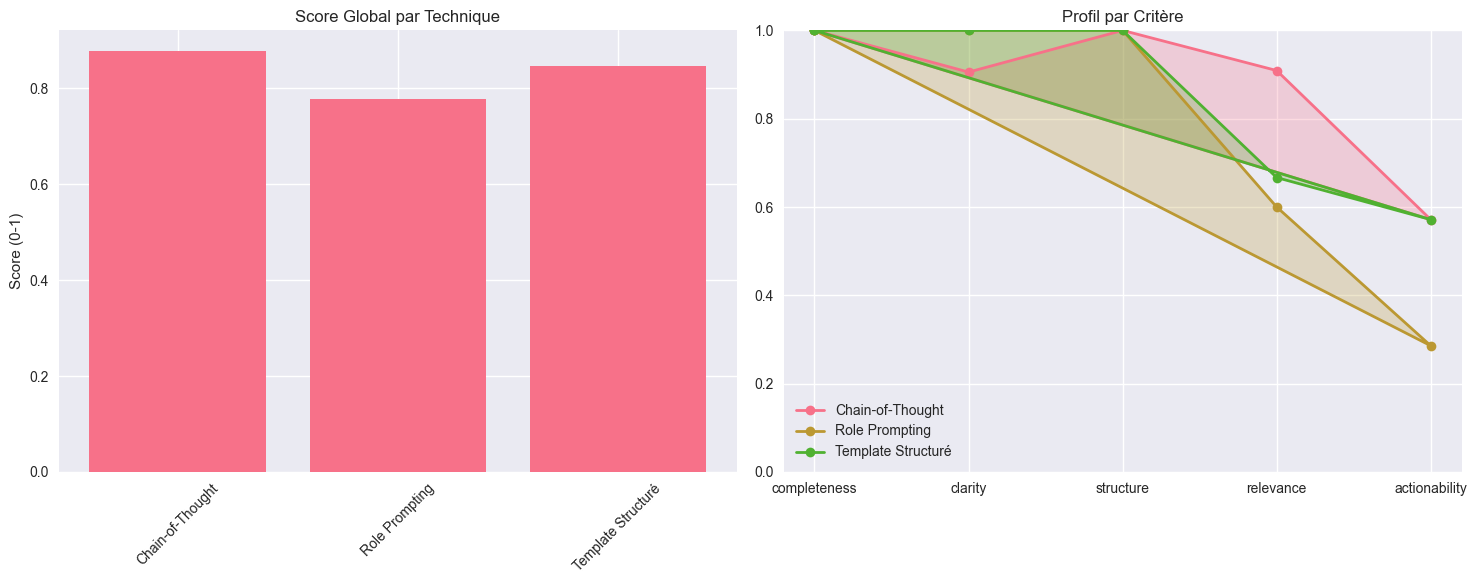



# 📊 RAPPORT DE PERFORMANCE DES PROMPTS

## 🎯 Vue d'ensemble
- Évaluations analysées : 3
- Score global moyen : 0.83/1.00
- Période : 2025-06-15 à 2025-06-15

## 📈 Scores par Critère
- Completeness : 1.00 ✅
- Clarity : 0.97 ✅
- Structure : 1.00 ✅
- Relevance : 0.73 ✅
- Actionability : 0.48 ❌



In [16]:
# Cas de test pour comparer les techniques
test_cases = [
    {
        "technique": "Chain-of-Thought",
        "use_case": "Résolution de problème",
        "prompt": "Résolvez étape par étape : Comment optimiser les performances d'une API ?",
        "response": """
## Optimisation des Performances d'API - Analyse Étape par Étape

### 1. **Diagnostic Initial**
- Identifier les goulots d'étranglement actuels
- Mesurer les temps de réponse par endpoint
- Analyser l'utilisation des ressources (CPU, mémoire, I/O)

### 2. **Optimisations Base de Données**
- Ajouter des index sur les colonnes fréquemment requêtées
- Optimiser les requêtes SQL complexes
- Implémenter la pagination pour les grandes listes

### 3. **Mise en Cache**
- Cache Redis pour les données fréquemment accédées
- Cache HTTP avec des headers appropriés
- Cache applicatif pour les calculs coûteux

### 4. **Architecture et Infrastructure**
- Load balancing pour distribuer la charge
- CDN pour les ressources statiques
- Compression gzip/brotli

### 5. **Monitoring et Mesure**
- Mise en place d'alertes sur les métriques clés
- Tests de charge réguliers
- Analyse continue des performances
"""
    },
    {
        "technique": "Role Prompting",
        "use_case": "Expertise technique",
        "prompt": "En tant qu'expert en performance web, expliquez comment optimiser une API.",
        "response": """
En tant qu'architecte senior avec 15 ans d'expérience, voici ma recommandation pour optimiser les performances d'API :

**DIAGNOSTIC PRIORITAIRE**
Utilisez des outils comme New Relic ou DataDog pour identifier précisément où se situent vos goulots. 80% du gain vient généralement de 20% des optimisations.

**STRATÉGIE EN 3 PHASES**
1. **Quick Wins** (Semaine 1-2) : Cache Redis, index DB, compression
2. **Optimisations Core** (Semaine 3-6) : Refactoring requêtes, async processing
3. **Architecture Scale** (Mois 2-3) : Microservices, CDN, load balancing

**MÉTRIQUES CLÉS À SURVEILLER**
- Latency P95 < 200ms
- Throughput > 1000 req/s
- Error rate < 0.1%

Implémentez par ordre de priorité business, pas technique.
"""
    },
    {
        "technique": "Template Structuré",
        "use_case": "Analyse systématique",
        "prompt": "Analysez les performances API selon le template d'analyse structurée.",
        "response": """
# ANALYSE : Optimisation Performance API

## 🎯 OBJECTIF
Améliorer les performances de l'API pour supporter une charge 5x supérieure

## 📊 EXECUTIVE SUMMARY
1. **Goulots identifiés** : Requêtes DB non optimisées (60% du temps)
2. **Quick wins disponibles** : Cache + index = gain 300%
3. **Investment requis** : 4-6 semaines, budget infrastructure +40%

## 🔍 ANALYSE DÉTAILLÉE

### Tendances Principales
- Dégradation linéaire avec la charge
- Pic d'utilisation 14h-16h
- 3 endpoints consomment 70% des ressources

### Points Critiques
- Timeout errors > 5% aux heures de pointe
- Pas de cache = requêtes répétitives
- DB connexions saturées

## 📋 PLAN D'ACTION PRIORISÉ
1. **Phase 1** (Semaine 1-2) : Cache Redis + index DB
2. **Phase 2** (Semaine 3-4) : Connection pooling + query optimization
3. **Phase 3** (Semaine 5-6) : Load balancing + monitoring

## 📈 MÉTRIQUES DE SUIVI
- Latency moyenne : < 100ms (actuellement 380ms)
- Taux d'erreur : < 0.5% (actuellement 3.2%)
- Satisfaction utilisateur : > 95%
"""
    }
]

print("🧪 ÉVALUATION COMPARATIVE DES TECHNIQUES")
print("=" * 50)

# Évaluation de chaque cas
comparison_df = evaluator.compare_techniques(test_cases)

print("📊 RÉSULTATS COMPARATIFS :")
print("-" * 30)
print(comparison_df.round(3))

# Visualisation des résultats
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Scores globaux par technique
axes[0].bar(comparison_df['technique'], comparison_df['overall_score'])
axes[0].set_title('Score Global par Technique')
axes[0].set_ylabel('Score (0-1)')
axes[0].tick_params(axis='x', rotation=45)

# Radar chart des critères
criteria = ['completeness', 'clarity', 'structure', 'relevance', 'actionability']
techniques = comparison_df['technique'].tolist()

for i, technique in enumerate(techniques):
    values = [comparison_df.iloc[i][criterion] for criterion in criteria]
    angles = np.linspace(0, 2*np.pi, len(criteria), endpoint=False).tolist()
    values += values[:1]  # Fermer le cercle
    angles += angles[:1]
    
    axes[1].plot(angles, values, 'o-', linewidth=2, label=technique)
    axes[1].fill(angles, values, alpha=0.25)

axes[1].set_xticks(angles[:-1])
axes[1].set_xticklabels(criteria)
axes[1].set_ylim(0, 1)
axes[1].set_title('Profil par Critère')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Rapport de performance
performance_report = evaluator.generate_performance_report()
print("\n" + performance_report)

## 🎯 6. Synthèse et Bibliothèque de Templates

Création d'une bibliothèque complète de templates prêts à l'emploi.

In [17]:
# Création d'une bibliothèque complète de templates
class PromptLibrary:
    """Bibliothèque complète de templates de prompts avancés"""
    
    def __init__(self):
        self.library = {
            "development": {
                "code_review": "Tu es un senior developer. Analyse ce code et fournis un feedback constructif avec des suggestions d'amélioration concrètes.",
                "architecture_design": "En tant qu'architecte logiciel, conçois une architecture pour {project_description}. Considère la scalabilité, la maintenabilité et les bonnes pratiques.",
                "debug_assistant": "Aide-moi à débugger ce problème étape par étape : {error_description}. Analyse les causes possibles et propose des solutions."
            },
            "business": {
                "strategy_analysis": "Analyse cette situation business et propose une stratégie : {situation}. Utilise un framework SWOT et donne des recommandations actionnables.",
                "market_research": "Effectue une analyse de marché pour {product_service} en considérant {target_market}. Identifie opportunités et menaces.",
                "roi_calculation": "Calcule et analyse le ROI pour {investment_description}. Présente les calculs étape par étape et les hypothèses."
            },
            "creative": {
                "content_creation": "Crée du contenu {content_type} pour {audience} sur le sujet {topic}. Ton : {tone}. Objectif : {goal}.",
                "storytelling": "Raconte une histoire engageante qui illustre {concept} pour une audience de {audience}. Utilise la structure narrative classique.",
                "brainstorming": "Générons des idées créatives pour {challenge}. Utilise la technique de pensée latérale et propose 10 idées diversifiées."
            },
            "education": {
                "explain_concept": "Explique {concept} à un niveau {level} en utilisant {method}. Utilise des analogies et des exemples concrets.",
                "create_exercise": "Crée un exercice pratique pour enseigner {skill} avec des critères d'évaluation clairs.",
                "curriculum_design": "Conçois un programme d'apprentissage pour {subject} destiné à {audience} sur une durée de {duration}."
            }
        }
        
    def get_template(self, category: str, template_name: str) -> str:
        """Récupérer un template spécifique"""
        if category in self.library and template_name in self.library[category]:
            return self.library[category][template_name]
        return None
    
    def list_categories(self) -> List[str]:
        """Lister toutes les catégories"""
        return list(self.library.keys())
    
    def list_templates(self, category: str) -> List[str]:
        """Lister les templates d'une catégorie"""
        if category in self.library:
            return list(self.library[category].keys())
        return []
    
    def search_templates(self, keyword: str) -> Dict[str, List[str]]:
        """Rechercher des templates par mot-clé"""
        results = {}
        
        for category, templates in self.library.items():
            matching_templates = []
            for template_name, template_text in templates.items():
                if keyword.lower() in template_name.lower() or keyword.lower() in template_text.lower():
                    matching_templates.append(template_name)
            
            if matching_templates:
                results[category] = matching_templates
                
        return results
    
    def export_library(self) -> str:
        """Exporter la bibliothèque en format JSON"""
        return json.dumps(self.library, indent=2, ensure_ascii=False)

# Création de la bibliothèque
prompt_library = PromptLibrary()

print("📚 BIBLIOTHÈQUE DE TEMPLATES AVANCÉS")
print("=" * 45)

# Affichage de la structure
for category in prompt_library.list_categories():
    templates = prompt_library.list_templates(category)
    print(f"\n🔸 {category.upper()} ({len(templates)} templates)")
    for template in templates:
        print(f"   • {template}")

print("\n🔍 EXEMPLE DE RECHERCHE :")
search_results = prompt_library.search_templates("analyse")
for category, templates in search_results.items():
    print(f"  📁 {category}: {', '.join(templates)}")

📚 BIBLIOTHÈQUE DE TEMPLATES AVANCÉS

🔸 DEVELOPMENT (3 templates)
   • code_review
   • architecture_design
   • debug_assistant

🔸 BUSINESS (3 templates)
   • strategy_analysis
   • market_research
   • roi_calculation

🔸 CREATIVE (3 templates)
   • content_creation
   • storytelling
   • brainstorming

🔸 EDUCATION (3 templates)
   • explain_concept
   • create_exercise
   • curriculum_design

🔍 EXEMPLE DE RECHERCHE :
  📁 development: code_review, debug_assistant
  📁 business: strategy_analysis, market_research, roi_calculation


## 🎓 Conclusion et Récapitulatif

### 🏆 Ce que Vous Avez Appris

1. **Chain-of-Thought** : Décomposition des problèmes complexes
2. **Role Prompting** : Personnalisation de l'expertise
3. **Few-Shot Learning** : Apprentissage par exemples
4. **Templates Avancés** : Systèmes réutilisables
5. **Évaluation** : Mesure de la qualité des prompts

### 🚀 Prochaines Étapes

- **Notebook 2** : Raisonnement et logique avancée (Tree-of-Thoughts)
- **Notebook 3** : Optimisation et évaluation automatique
- **Notebook 4** : Systèmes dynamiques et adaptatifs

In [18]:
# Sauvegarde des résultats et templates pour les prochains notebooks
import pickle

# Données à sauvegarder
session_data = {
    "prompt_engine": prompt_engine,
    "role_generator": role_generator,
    "few_shot_generator": few_shot_generator,
    "template_system": template_system,
    "evaluator": evaluator,
    "prompt_library": prompt_library,
    "api_clients": api_clients
}

# Sauvegarde
try:
    with open('advanced_prompting_session.pkl', 'wb') as f:
        pickle.dump(session_data, f)
    print("✅ Session sauvegardée avec succès !")
except Exception as e:
    print(f"⚠️ Erreur de sauvegarde : {e}")

print("\n🎯 RÉCAPITULATIF DE LA SESSION")
print("=" * 35)
print(f"• Templates créés : {len(template_system.templates)}")
print(f"• Rôles disponibles : {len(role_generator.roles)}")
print(f"• Types Few-Shot : {len(few_shot_generator.example_sets)}")
print(f"• Évaluations effectuées : {len(evaluator.evaluation_history)}")
print(f"• Bibliothèque : {sum(len(templates) for templates in prompt_library.library.values())} templates")

print("\n✨ Vous maîtrisez maintenant les techniques avancées de prompt engineering !")
print("📚 Prêt pour le Notebook 2 : Raisonnement et Logique Avancée")

⚠️ Erreur de sauvegarde : cannot pickle '_thread.RLock' object

🎯 RÉCAPITULATIF DE LA SESSION
• Templates créés : 3
• Rôles disponibles : 4
• Types Few-Shot : 3
• Évaluations effectuées : 3
• Bibliothèque : 12 templates

✨ Vous maîtrisez maintenant les techniques avancées de prompt engineering !
📚 Prêt pour le Notebook 2 : Raisonnement et Logique Avancée
